In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.probability import FreqDist

from data_preprocesser import preprocessed_data_path

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

FileNotFoundError: [Errno 2] File b'./data_yelp/raw/csv/yelp_business.csv' does not exist: b'./data_yelp/raw/csv/yelp_business.csv'

In [2]:
df = pd.read_csv(preprocessed_data_path + 'categories_30000/yelp_academic_dataset_review_Auto Repair.csv')
df.head()

,review_id,business_id,stars_x,stars_y,date,city,text,categories
0,JN0tmjiksWfr4i2NIFuPXw,pLZ9oZM8c6MNbRlg06lBPg,1,3.0,2016-08-03,Las Vegas,THEY SELL WRECKED VEHICLES! \nI purchased a 20...,Auto Repair;Car Dealers;Automotive;Auto Parts ...
1,lFmz61DNRzBPnrwH_cF42g,J0KZR0DDnvj73D-xmbh4uA,4,4.0,2017-06-15,Las Vegas,I stopped in here recently as I had to buy a t...,Auto Parts & Supplies;Auto Repair;Automotive
2,R9p3ug8zNPvawYX_jsO0UA,Tknj3u-3CZTI-q52saTAIA,1,1.0,2012-09-12,Toronto,"If you want the ""I don't give a shit "" attitud...",Car Dealers;Auto Repair;Automotive
3,FMXER_6R6URYBpV6TYPn9A,rV1nkTx58v_q7YGDkGzfxQ,5,5.0,2016-06-10,Las Vegas,where to start...\na few months ago I slammed....,Auto Repair;Automotive
4,bJN2ZPa0jF4xgR1gPKZP3A,hCXknMQalY1QQZrdZGuBHg,3,3.5,2017-01-24,Las Vegas,I have mixed feelings here. I recently purchas...,Car Dealers;Auto Repair;Automotive


In [5]:
# Processing Functions
def identify_tokens(row):
    review = row['text']
    tokens = nltk.word_tokenize(review)
    # taken only words (not punctuation)
    # token_words = [re.sub("[^\w\s]", " ", w) for w in tokens]
    token_words = [w for w in tokens if w.isalpha()]
    return token_words

stops = set(stopwords.words("english"))                  

def remove_stops(row):
    my_list = row['words']
    meaningful_words = [w for w in my_list if not w in stops and w != " "]
    return (meaningful_words)

stemming = PorterStemmer()

def stem_list(row):
    my_list = row['words_meaningful']
    stemmed_list = [stemming.stem(word) for word in my_list]
    return (stemmed_list)

lemming = WordNetLemmatizer()

def lem_list(row):
    my_list = row['words_non_stop']
    lemmed_list = [lemming.lemmatize(word) for word in my_list]
    return (lemmed_list)

def rejoin_words(row):
    my_list = row['words_meaningful']
    joined_words = ( " ".join(my_list))
    return joined_words

In [6]:
def process(data_df):
    data_df['text'] = data_df['text'].str.lower()
    data_df['words'] = data_df.apply(identify_tokens, axis=1)
    data_df['words_non_stop'] = data_df.apply(remove_stops, axis=1)
    data_df['words_meaningful'] = data_df.apply(lem_list, axis=1)
    data_df['processed'] = data_df.apply(rejoin_words, axis=1)
    return data_df

In [7]:
df_processed = process(df)

In [8]:
text = " ".join(review for review in df['processed'])
print ("There are {} words in the combination of all review.".format(len(text)))

There are 11509080 words in the combination of all review.


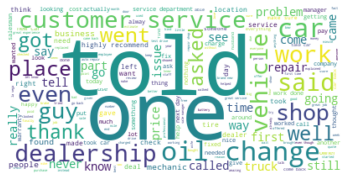

In [9]:
# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# LDA

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(max_df=0.8, min_df=2, stop_words='english')
doc_term_matrix = count_vect.fit_transform(df['processed'].values.astype('U'))

doc_term_matrix

<30000x15168 sparse matrix of type '<class 'numpy.int64'>'
	with 1185103 stored elements in Compressed Sparse Row format>

In [11]:
from sklearn.decomposition import LatentDirichletAllocation

LDA = LatentDirichletAllocation(n_components=5)
LDA.fit(doc_term_matrix)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [12]:
for i,topic in enumerate(LDA.components_):
    print(f'Top 10 words for topic #{i}:')
    print([count_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['oil', 'hour', 'called', 'day', 'said', 'time', 'told', 'tire', 'service', 'car']


Top 10 words for topic #1:
['new', 'replaced', 'time', 'problem', 'work', 'took', 'said', 'told', 'car', 'brake']


Top 10 words for topic #2:
['guy', 'best', 'friendly', 'time', 'recommend', 'customer', 'work', 'car', 'great', 'service']


Top 10 words for topic #3:
['wanted', 'deal', 'time', 'price', 'new', 'experience', 'vehicle', 'sale', 'dealership', 'car']


Top 10 words for topic #4:
['auto', 'price', 'work', 'place', 'change', 'mechanic', 'repair', 'oil', 'shop', 'car']




# NMF

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(max_df=0.8, min_df=2, stop_words='english')
doc_term_matrix = tfidf_vect.fit_transform(df['processed'].values.astype('U'))

In [14]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=5)
nmf.fit(doc_term_matrix)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=5, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [15]:
for i,topic in enumerate(nmf.components_):
    print(f'Top 10 words for topic #{i}:')
    print([tfidf_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['went', 'experience', 'new', 'sale', 'said', 'time', 'day', 'told', 'dealership', 'car']


Top 10 words for topic #1:
['brake', 'minute', 'time', 'changed', 'filter', 'service', 'appointment', 'hour', 'change', 'oil']


Top 10 words for topic #2:
['highly', 'definitely', 'experience', 'helpful', 'staff', 'recommend', 'friendly', 'customer', 'great', 'service']


Top 10 words for topic #3:
['went', 'said', 'rotation', 'told', 'discount', 'nail', 'alignment', 'flat', 'new', 'tire']


Top 10 words for topic #4:
['brake', 'need', 'car', 'place', 'mechanic', 'auto', 'honest', 'work', 'repair', 'shop']




# Gensim LDA

In [16]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

In [17]:
# Create Dictionary
id2word = corpora.Dictionary(df['words_meaningful'])

# Create Corpus
texts = df['words_meaningful']

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [18]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('absolutely', 1),
  ('accident', 1),
  ('advise', 1),
  ('altima', 1),
  ('another', 1),
  ('avoid', 1),
  ('began', 1),
  ('bit', 1),
  ('bought', 1),
  ('brake', 1),
  ('car', 3),
  ('caused', 1),
  ('charged', 1),
  ('clue', 1),
  ('constant', 1),
  ('consumer', 1),
  ('damage', 1),
  ('dealership', 2),
  ('decided', 1),
  ('drove', 1),
  ('every', 1),
  ('except', 1),
  ('exhaust', 1),
  ('finally', 1),
  ('found', 1),
  ('frame', 1),
  ('go', 1),
  ('high', 1),
  ('immediately', 1),
  ('involved', 1),
  ('knowing', 1),
  ('major', 1),
  ('make', 1),
  ('manufacturer', 1),
  ('mean', 1),
  ('mile', 1),
  ('month', 2),
  ('much', 1),
  ('nissan', 3),
  ('planet', 2),
  ('pocket', 1),
  ('possible', 1),
  ('powertrain', 1),
  ('prior', 1),
  ('problem', 1),
  ('process', 1),
  ('provided', 1),
  ('purchased', 1),
  ('purchasing', 1),
  ('repair', 2),
  ('reputable', 1),
  ('savvy', 1),
  ('sell', 1),
  ('selling', 1),
  ('sick', 1),
  ('six', 1),
  ('sold', 1),
  ('someplace', 1),

In [19]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [20]:
for (i,topic) in enumerate(lda_model.print_topics()):
    print(f'Top words for topic #{i}:')
    print([i for i in topic[1].split('"') if str(i).isalpha()])
    print('\n')

Top words for topic #0:
['oil', 'tire', 'change', 'problem', 'part', 'took', 'brake', 'needed', 'new', 'fix']


Top words for topic #1:
['truck', 'year', 'transmission', 'problem', 'ford', 'air', 'filter', 'knowledgeable', 'issue', 'vega']


Top words for topic #2:
['car', 'would', 'get', 'back', 'time', 'could', 'told', 'one', 'day', 'said']


Top words for topic #3:
['dealership', 'u', 'vehicle', 'sale', 'new', 'experience', 'deal', 'car', 'wanted', 'buy']


Top words for topic #4:
['service', 'car', 'great', 'work', 'shop', 'customer', 'place', 'price', 'good', 'repair']




In [21]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=df['words_meaningful'], dictionary=id2word, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.373727976910481

Coherence Score:  0.40206582212320097


In [22]:
#pyLDAvis.enable_notebook()
#vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
#vis

# Mallet

In [57]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# You need Java !
mallet_path = '/home/arthur/BNPP_Sentiment_Analysis/mallet-2.0.8/bin/mallet' 
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=5, id2word=id2word, topic_threshold=0.25)

In [58]:
for (i,topic) in enumerate(ldamallet.print_topics()):
    print(f'Top words for topic #{i}:')
    print([i for i in topic[1].split('"') if str(i).isalpha()])
    print('\n')

Top words for topic #0:
['car', 'dealership', 'vehicle', 'experience', 'price', 'sale', 'deal', 'wanted', 'manager', 'dealer']


Top words for topic #1:
['service', 'great', 'recommend', 'customer', 'place', 'honest', 'guy', 'work', 'friendly', 'good']


Top words for topic #2:
['back', 'told', 'time', 'called', 'call', 'hour', 'day', 'asked', 'service', 'customer']


Top words for topic #3:
['car', 'time', 'work', 'repair', 'truck', 'service', 'day', 'vehicle', 'back', 'issue']


Top words for topic #4:
['oil', 'tire', 'change', 'needed', 'problem', 'mechanic', 'part', 'shop', 'place', 'brake']




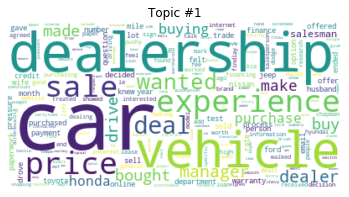

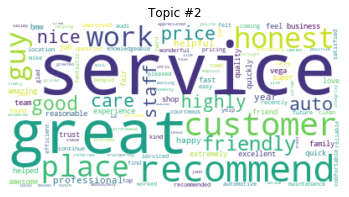

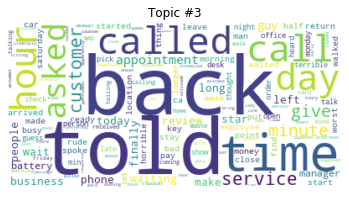

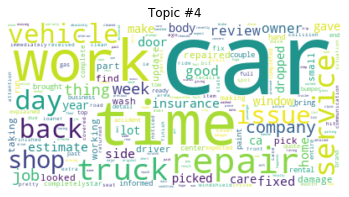

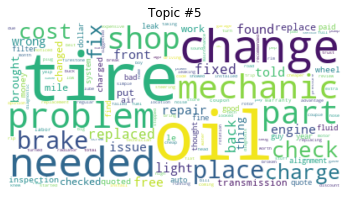

In [59]:
for t in range(ldamallet.num_topics):
    plt.figure()
    plt.imshow(WordCloud(background_color="white").fit_words(dict(ldamallet.show_topic(t, 200))), interpolation='bilinear')
    plt.axis("off")
    plt.title("Topic #" + str(t + 1))
    plt.show()

In [25]:
coherence_model_lda = CoherenceModel(model=ldamallet, texts=df['words_meaningful'], dictionary=id2word, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.45128500720711584


In [26]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [27]:
model_list, coherence_values = compute_coherence_values(
    dictionary=id2word,
    corpus=corpus, 
    texts=df['words_meaningful'], 
    start=2, 
    limit=30, 
    step=5)

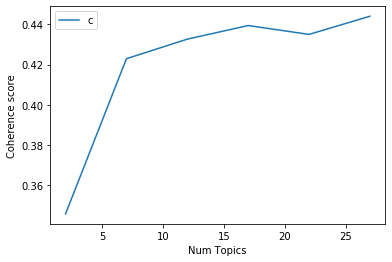

In [28]:
limit=30 
start=2
step=5
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [45]:
model_list, coherence_values = compute_coherence_values(
    dictionary=id2word,
    corpus=corpus, 
    texts=df['words_meaningful'], 
    start=2, 
    limit=10, 
    step=1)

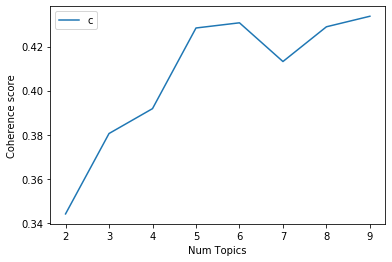

In [46]:
limit=10 
start=2
step=1
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Word2Vec

In [31]:
from gensim.models import Word2Vec

In [32]:
model = Word2Vec(df['words_meaningful'], min_count=1, size= 50,workers=3, window=3)

In [33]:
model.most_similar('car')[:10]

/home/arthur/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('vehicle', 0.9027617573738098),
 ('truck', 0.8558082580566406),
 ('van', 0.627893328666687),
 ('jeep', 0.6175321340560913),
 ('wouldly', 0.617306113243103),
 ('suv', 0.6123770475387573),
 ('yet', 0.5550999045372009),
 ('actually', 0.5445128679275513),
 ('husband', 0.5270068645477295),
 ('planned', 0.5218650698661804)]

In [34]:
X = model[model.wv.vocab]
X.shape

/home/arthur/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


(27955, 50)

In [35]:
from sklearn import cluster
from sklearn import metrics

## KMeans

In [36]:
def test_kmeans(num_clusters_max):
    for i in range(2, num_clusters_max):
        print("For " + str(i) + " clusters")
        kmeans = cluster.KMeans(n_clusters=i)
        kmeans.fit(X)
 
        labels = kmeans.labels_
        centroids = kmeans.cluster_centers_
        
        silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')

        print ("Silhouette_score: ")
        print (silhouette_score)

In [37]:
num_clusters_max = 10
test_kmeans(num_clusters_max)

For 2 clusters
Silhouette_score: 
0.67587566
For 3 clusters
Silhouette_score: 
0.6422493
For 4 clusters
Silhouette_score: 
0.6381593
For 5 clusters
Silhouette_score: 
0.61657727
For 6 clusters
Silhouette_score: 
0.6036447
For 7 clusters
Silhouette_score: 
0.5997317
For 8 clusters
Silhouette_score: 
0.59575826
For 9 clusters
Silhouette_score: 
0.59561914


Keeping 5 clusters :

In [38]:
kmeans = cluster.KMeans(n_clusters=5)
kmeans.fit(X)

labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [39]:
clusters_list = list(set(labels))
all_words = model.wv.index2word
all_words_meaningful = [item for sublist in df['words_meaningful'].tolist() for item in sublist]
print("TOTAL : {} unique words".format(len(list(set(all_words_meaningful)))))
print("TOTAL : {} meaningful words".format(len(all_words_meaningful)))
print("TOTAL : ratio is {}".format(round(len(list(set(all_words_meaningful)))/len(all_words_meaningful), 5)))

for cluster_id in clusters_list:
    indices = [i for i, x in enumerate(labels) if x == cluster_id]
    print("CLUSTER {} : {} unique words".format(cluster_id, len(indices)))

def visualize_clusters(labels, clusters_blacklist = [0]):   
    clusters_whitelist = [cluster_id for cluster_id in clusters_list if cluster_id not in clusters_blacklist]
    for cluster_id in clusters_whitelist:
        # We want to find the words associated to the cluster
        indices = [i for i, x in enumerate(labels) if x == cluster_id]
        print("CLUSTER {} : {} unique words".format(cluster_id, len(indices)))
        words = [all_words[i] for i in indices]
        words_meaningful = [word for word in all_words_meaningful if word in words]
        
        print("CLUSTER {} : {} meaningful words in the uniques words list".format(cluster_id, len(words_meaningful)))
        print("CLUSTER {} : ratio is {}".format(cluster_id, round(len(indices)/len(words_meaningful), 5)))

        sub_text = " ".join(words_meaningful)
        
        wordcloud = WordCloud(background_color="white").generate(sub_text)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()

        


TOTAL : 27955 unique words
TOTAL : 1760567 meaningful words
TOTAL : ratio is 0.01588
CLUSTER 0 : 22270 unique words
CLUSTER 1 : 4310 unique words
CLUSTER 2 : 452 unique words
CLUSTER 3 : 530 unique words
CLUSTER 4 : 393 unique words


CLUSTER 1 : 4310 unique words
CLUSTER 1 : 581663 meaningful words in the uniques words list
CLUSTER 1 : ratio is 0.00741


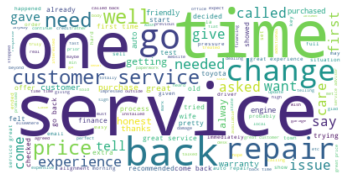

CLUSTER 2 : 452 unique words
CLUSTER 2 : 193229 meaningful words in the uniques words list
CLUSTER 2 : ratio is 0.00234


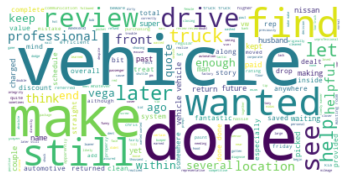

CLUSTER 3 : 530 unique words
CLUSTER 3 : 624807 meaningful words in the uniques words list
CLUSTER 3 : ratio is 0.00085


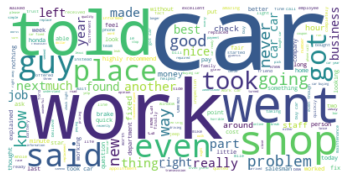

CLUSTER 4 : 393 unique words
CLUSTER 4 : 187977 meaningful words in the uniques words list
CLUSTER 4 : ratio is 0.00209


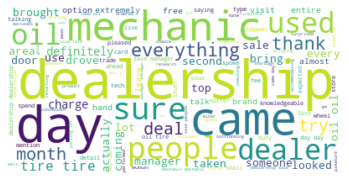

In [40]:
visualize_clusters(labels, [0])

## DBSCAN

In [41]:
dbscan = cluster.DBSCAN(eps=1, min_samples=100)
dbscan.fit(X)

DBSCAN(algorithm='auto', eps=1, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=100, n_jobs=None, p=None)

In [42]:
labels = dbscan.labels_
clusters_list = list(set(labels))

for cluster_id in clusters_list:
    indices = [i for i, x in enumerate(labels) if x == cluster_id]
    print("CLUSTER {} : {} unique words".format(cluster_id, len(indices)))

CLUSTER 0 : 24987 unique words
CLUSTER -1 : 2968 unique words


In [43]:
dbscan = cluster.DBSCAN(eps=0.1, min_samples=5)
dbscan.fit(X)

DBSCAN(algorithm='auto', eps=0.1, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [44]:
labels = dbscan.labels_
clusters_list = list(set(labels))

for cluster_id in clusters_list:
    indices = [i for i, x in enumerate(labels) if x == cluster_id]
    print("CLUSTER {} : {} unique words".format(cluster_id, len(indices)))

CLUSTER 0 : 8783 unique words
CLUSTER 1 : 5 unique words
CLUSTER 2 : 4 unique words
CLUSTER -1 : 19163 unique words
